## Import Statments

In [1]:
#Imports
#Data processing
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#ML libs
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

## Import Data

In [257]:
#Import features of each production well into dfProd
dfProd = pd.read_csv(r"../well_data/wellbore_data_producer_wells.csv")
dfPreProd = pd.read_csv(r"../well_data/wellbore_data_preproduction_well.csv")

In [258]:
ordinal_mapper = {'Sandstone': 3, 'Sandy shale': 1, 'Shaly sandstone': 2, 'Shale': 0}
dfPreProd['Rock facies'] = dfPreProd['Rock facies'].replace(ordinal_mapper)

In [259]:
dfPreProd

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,Well_no_74,7925,5525,3050.51,NaN,NaN,7842692.077,1.0,NaN,3387.576377,NaN,1646.603549,6.229941
1,Well_no_74,7925,5525,3051.01,0.09096,NaN,7807355.262,2.0,1.872982,NaN,NaN,1465.051728,4.930174
2,Well_no_74,7925,5525,3051.51,0.05878,NaN,7864859.402,1.0,3.187123,2660.306664,18.875428,1570.481116,7.202703
3,Well_no_74,7925,5525,3052.01,NaN,NaN,7309508.797,2.0,2.058578,3285.615950,26.992396,1652.096739,6.486131
4,Well_no_74,7925,5525,3052.51,0.12285,NaN,7328552.658,2.0,1.678339,4432.429019,35.261378,1697.320552,3.802001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Well_no_83,6375,3725,3055.60,0.14881,148.679689,6831566.178,3.0,2.137782,3325.937404,NaN,1753.017481,NaN
196,Well_no_83,6375,3725,3056.10,NaN,NaN,7106579.168,3.0,2.356128,3026.561084,25.395808,1644.259998,NaN
197,Well_no_83,6375,3725,3056.60,0.16041,NaN,7058678.769,3.0,1.593845,4219.472157,30.200434,1601.108802,4.634619
198,Well_no_83,6375,3725,3057.10,NaN,189.001076,7043097.566,3.0,1.490938,4570.820320,31.485428,1583.303027,5.610245


In [260]:
PreWells = dfPreProd["Well_ID"].unique()

In [261]:
dfPreProd["Well_ID"] = dfPreProd["Well_ID"].str[8:].astype(int)

In [262]:
dfPreWells = dfPreProd.groupby(dfPreProd["Well_ID"]).mean()

In [263]:
dfPreWells['Fault Distance, m'] = (((-1)*dfPreWells['X, m'])+((-1)*dfPreWells['Y, m'])+11750).abs()/np.sqrt(2)

In [264]:
dfPreWells

,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Fault Distance, m"
Well_ID,,,,,,,,,,,,,
74,7925,5525,3055.26,0.122976,86.199024,7.386720e+06,2.150000,2.113875,3497.399163,25.438942,1641.413329,6.114323,1202.081528
75,8125,4425,3054.59,0.123025,71.992542,7.393464e+06,1.894737,1.954353,3911.754285,28.704497,1644.080134,5.542214,565.685425
76,7725,4625,3054.01,0.133903,195.267385,7.246248e+06,2.117647,2.079348,3592.473231,28.003328,1658.458824,5.845536,424.264069
77,6825,4475,3052.51,0.138701,128.974715,7.254626e+06,2.473684,2.157615,3526.262903,24.569174,1666.223529,6.311062,318.198052
78,7425,3975,3053.76,0.133512,151.252341,7.291226e+06,2.315789,1.927381,3695.171078,28.522719,1705.296805,5.345275,247.487373
79,6875,4125,3052.88,0.145885,113.852064,7.194660e+06,2.333333,1.887621,3847.731545,29.519405,1702.218032,5.454473,530.330086
80,7525,4925,3053.74,0.124953,82.326745,7.355745e+06,2.277778,2.266880,3331.845076,26.308584,1660.546761,6.292982,494.974747
81,9025,4825,3056.42,0.122341,117.458572,7.390554e+06,2.157895,1.862495,4206.389963,29.180389,1625.705857,5.476935,1484.924240
82,6025,4425,3051.49,0.122789,126.921596,7.312159e+06,2.200000,2.195301,3304.759974,24.742882,1694.248092,6.333516,919.238816


In [265]:
sandy_array = np.load(r"..\map_data\2d_sand_propotion.npy")
ai_array = np.load(r"..\map_data\2d_ai.npy")
sandy_shale = np.load(r"..\map_data\2d_sandy_shale_propotion.npy")
shale_array = np.load(r"..\map_data\2d_shale_propotion.npy")
shaly_sand = np.load(r"..\map_data\2d_shaly_sand_propotion.npy")
top_depth = np.load(r"..\map_data\2d_top_depth.npy")

## Data Prep

Instead of KNN or overall mean imputation, the following values should have a value that can be determined as an average over the entire well and applied (well-by-well imputation)

In [8]:
ordinal_mapper = {'Sandstone': 3, 'Sandy shale': 1, 'Shaly sandstone': 2, 'Shale': 0}
dfProd['Rock facies'] = dfProd['Rock facies'].replace(ordinal_mapper)

In [9]:
dfProd.dtypes

Well_ID                           int32
X, m                              int64
Y, m                              int64
Depth, m                        float64
Porosity, fraction              float64
Permeability, mD                float64
Acoustic Impedance, kg*s/m^2    float64
Rock facies                     float64
Density, g/cm3                  float64
Compressible velocity, m/s      float64
Youngs modulus, GPa             float64
Shear velocity, m/s             float64
Shear modulus, GPa              float64
dtype: object

## Row Combination

In [10]:
imputer = KNNImputer(n_neighbors=3)

In [11]:
dfProd.describe()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,1460.000000,1460.000000,1460.000000,1460.000000,1268.000000,284.000000,1.357000e+03,1330.000000,1248.000000,1276.000000,1261.000000,1270.000000,1285.000000
mean,37.000000,4188.698630,5770.890411,3055.810959,0.127746,112.182739,7.325786e+06,2.185714,2.052521,3688.657853,27.288877,1676.158075,5.752640
std,21.078527,1771.495039,2389.773641,4.353335,0.036020,80.894436,3.101125e+05,0.960126,0.417622,727.216238,5.424608,100.630094,1.518699
min,1.000000,1175.000000,775.000000,3045.620000,0.040270,2.214604,6.559277e+06,0.000000,1.421943,1661.828496,13.205134,1307.887097,1.650985
25%,19.000000,2925.000000,3825.000000,3052.720000,0.113953,51.540980,7.111056e+06,2.000000,1.734052,3178.389486,23.466538,1608.928309,4.757475
50%,37.000000,3875.000000,6125.000000,3055.790000,0.137495,93.980722,7.274333e+06,2.000000,1.988542,3664.196826,26.647466,1674.836574,5.610267
75%,55.000000,5325.000000,7625.000000,3058.982500,0.152325,154.584890,7.503378e+06,3.000000,2.229507,4214.924966,30.874629,1746.081251,6.600503
max,73.000000,7975.000000,9775.000000,3066.300000,0.188910,489.219402,8.249272e+06,3.000000,3.530373,6179.653016,48.123292,1989.829247,11.820038


In [12]:
dfProd.isna().sum()

Well_ID                            0
X, m                               0
Y, m                               0
Depth, m                           0
Porosity, fraction               192
Permeability, mD                1176
Acoustic Impedance, kg*s/m^2     103
Rock facies                      130
Density, g/cm3                   212
Compressible velocity, m/s       184
Youngs modulus, GPa              199
Shear velocity, m/s              190
Shear modulus, GPa               175
dtype: int64

In [13]:
X = dfProd.drop("Well_ID", axis=1)

In [14]:
dfProdimputed = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)

In [15]:
dfProduced = pd.read_csv(r"..\prod_data\production_history.csv")

In [16]:
dfProduced["Well_ID"] = dfProduced["Well_ID"].str[8:].astype(int)

In [17]:
dfWells = dfProd.groupby(dfProd["Well_ID"]).mean()

In [83]:
dfWells['Fault Distance, m'] = (((-1)*dfWells['X, m'])+((-1)*dfWells['Y, m'])+11750).abs()/np.sqrt(2)

In [96]:
dfWells

,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Fault Distance, m"
Well_ID,,,,,,,,,,,,,
1,7325,7175,3057.55,0.133426,189.116974,7.232823e+06,2.600000,2.141876,3392.897466,25.674891,1656.844649,6.357954,1944.543648
2,4225,3525,3052.54,0.128885,176.367428,7.323769e+06,2.157895,2.064860,3514.562352,25.284289,1673.452546,6.436651,2828.427125
3,7725,8275,3060.67,0.118062,119.421584,7.340299e+06,2.133333,1.951313,3972.826143,27.938946,1676.017976,5.699668,3005.203820
4,4425,6475,3051.61,0.138111,151.595670,7.302308e+06,2.500000,1.910705,3675.865373,27.021138,1651.691173,5.432418,601.040764
5,2125,1225,3060.45,0.130910,123.891145,7.346910e+06,2.000000,1.917131,3790.337407,27.761162,1709.912999,5.262329,5939.696962
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,3375,775,3059.64,0.124074,166.810299,7.418335e+06,2.000000,1.907549,3996.551094,29.141045,1677.668722,5.317462,5374.011537
70,3575,9775,3060.30,0.139168,201.311447,7.273654e+06,2.315789,2.306208,3308.578249,25.009714,1682.541663,6.593852,1131.370850
71,6975,6525,3055.04,0.133675,105.286049,7.220738e+06,2.450000,2.086910,3649.363331,27.553182,1655.008020,5.247501,1237.436867


In [97]:
dfProd_indexed = dfProduced.set_index("Well_ID")

In [98]:
dfProdFull = pd.concat([dfWells, dfProd_indexed], axis=1)

In [99]:
unneeded = ["Cumulative oil production (1 yr), MSTB", 
              "Cumulative oil production (2 yr), MSTB",
              "Cumulative Water production (1 yr), MSTB", 
              "Cumulative Water production (2 yr), MSTB", 
              "Cumulative Water production (3 yr), MSTB"]
dfProdFinal = dfProdFull.drop(unneeded, axis=1)
dfProdFinal.corr()

,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Fault Distance, m","Cumulative oil production (3 yr), MSTB"
"X, m",1.000000,0.457665,-0.093746,0.293142,0.254115,-0.338710,0.538345,0.520609,-0.531674,-0.502162,-0.070208,0.434179,-0.459098,0.222396
"Y, m",0.457665,1.000000,0.112255,0.238360,0.158341,-0.264973,0.385094,0.510437,-0.500309,-0.489815,-0.020894,0.384918,-0.791663,0.037999
"Depth, m",-0.093746,0.112255,1.000000,-0.175716,-0.217101,0.188775,-0.175619,-0.162886,0.276573,0.269352,-0.146121,-0.175220,0.415650,-0.486005
"Porosity, fraction",0.293142,0.238360,-0.175716,1.000000,0.657208,-0.890418,0.862297,0.243881,-0.467441,-0.541068,-0.001359,0.177810,-0.309083,0.763920
"Permeability, mD",0.254115,0.158341,-0.217101,0.657208,1.000000,-0.716629,0.558934,0.277257,-0.449660,-0.518060,-0.134847,0.290709,-0.235404,0.692084
"Acoustic Impedance, kg*s/m^2",-0.338710,-0.264973,0.188775,-0.890418,-0.716629,1.000000,-0.848267,-0.263932,0.475904,0.562357,0.051557,-0.170844,0.318248,-0.722983
Rock facies,0.538345,0.385094,-0.175619,0.862297,0.558934,-0.848267,1.000000,0.449704,-0.568906,-0.660525,-0.041267,0.353018,-0.443180,0.643482
"Density, g/cm3",0.520609,0.510437,-0.162886,0.243881,0.277257,-0.263932,0.449704,1.000000,-0.873507,-0.862518,0.071725,0.819730,-0.574002,0.193598
"Compressible velocity, m/s",-0.531674,-0.500309,0.276573,-0.467441,-0.449660,0.475904,-0.568906,-0.873507,1.000000,0.883706,-0.159817,-0.757241,0.595346,-0.425556
"Youngs modulus, GPa",-0.502162,-0.489815,0.269352,-0.541068,-0.518060,0.562357,-0.660525,-0.862518,0.883706,1.000000,-0.079031,-0.717516,0.589871,-0.444470


In [302]:
dfProdFinal.describe()

,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa","Fault Distance, m","Cumulative oil production (3 yr), MSTB"
count,73.000000,73.000000,73.000000,73.000000,73.000000,7.300000e+01,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,4188.698630,5770.890411,3055.810959,0.127886,113.409308,7.326029e+06,2.185454,2.052559,3692.465430,27.306561,1676.124958,5.751262,2275.334012,940.976027
std,1783.143687,2405.487844,3.282321,0.011534,53.227536,9.705732e+04,0.321203,0.148083,275.928692,2.132350,22.791342,0.447604,1679.899239,429.622150
min,1175.000000,775.000000,3050.370000,0.103266,17.692998,7.041786e+06,1.473684,1.784384,3226.716917,23.926022,1629.142399,4.952945,106.066017,307.120000
25%,2925.000000,3825.000000,3052.790000,0.119792,77.784480,7.287669e+06,2.000000,1.917867,3444.442189,25.499713,1657.608521,5.331215,954.594155,643.140000
50%,3875.000000,6125.000000,3055.810000,0.128884,99.067583,7.334721e+06,2.133333,2.018872,3688.453880,27.021138,1676.017976,5.708991,1944.543648,819.490000
75%,5325.000000,7625.000000,3058.310000,0.134574,141.908305,7.379185e+06,2.450000,2.173899,3906.539696,29.041203,1690.990515,6.137787,3217.335854,1185.400000
max,7975.000000,9775.000000,3061.550000,0.163979,262.406426,7.498752e+06,2.789474,2.343984,4355.738959,31.787065,1727.196584,6.593852,6363.961031,2514.500000


In [100]:
X = dfProdFinal.drop(["Cumulative oil production (3 yr), MSTB"], axis=1)
y = dfProdFinal["Cumulative oil production (3 yr), MSTB"]

In [101]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)

## XGB Regression

In [102]:
model = xgb.XGBRFRegressor(random_state=1)

In [103]:
model.fit(train_X, train_y)

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=12, num_parallel_tree=100,
               objective='reg:squarederror', random_state=1, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

In [104]:
preds = model.predict(test_X)

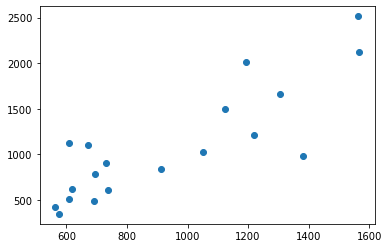

In [105]:
plt.scatter(preds, test_y)

In [106]:
mae = mean_absolute_error(preds, test_y)

In [107]:
print(mae)

293.7424714740954


In [108]:
test_y.mean()

1093.101052631579

In [109]:
def model_run(X, y, seed):
    train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=seed)
    model = xgb.XGBRFRegressor(random_state=42)
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    mae = mean_absolute_error(preds, test_y)
    return mae

In [110]:
total_mae = []
for i in range(100):
    total_mae.append(model_run(X,y,i))

In [111]:
print(y.mean(), np.mean(total_mae), np.mean(total_mae)/y.mean())

940.9760273972605 220.67264517179788 0.23451463028466132


In [33]:
print("Percent Error: ", mae/test_y.mean())

Percent Error:  0.2628422553001898


## Linear Regression

In [112]:
lin_model = LinearRegression(n_jobs=-1, normalize=True)

In [138]:
lin_model

LinearRegression(n_jobs=-1, normalize=True)

In [113]:
lin_model.fit(train_X, train_y)

LinearRegression(n_jobs=-1, normalize=True)

In [114]:
lin_preds = lin_model.predict(test_X)

In [115]:
lin_mae = mean_absolute_error(lin_preds, test_y)

In [116]:
print("Percent Error: ", lin_mae/test_y.mean())

Percent Error:  0.21644072945736328


In [292]:
def model_generator(X, y, seed):
    train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=seed)
    model = xgb.XGBRFRegressor(random_state=42, n_jobs=-1)
    model.fit(train_X, train_y)
    return model

In [293]:
models = []
for i in range(100):
    models.append(model_generator(X,y,i))

In [294]:
names = []
for i in range(100):
    names.append("R"+ str(i+1) + ", MSTB")

In [324]:
predictions = np.array([])
for model in models:
    predictions = np.append(predictions, np.array(model.predict(dfPreWells)))
    
predictions = pd.DataFrame(predictions.reshape(100,10).T, columns=names)

In [325]:
predictions["Well_ID"] = PreWells

In [326]:
predictions["Prediction, MSTB"] = predictions.median(axis=1)

In [327]:
print(["Well_ID", "Prediction, MSTB"] + names)

['Well_ID', 'Prediction, MSTB', 'R1, MSTB', 'R2, MSTB', 'R3, MSTB', 'R4, MSTB', 'R5, MSTB', 'R6, MSTB', 'R7, MSTB', 'R8, MSTB', 'R9, MSTB', 'R10, MSTB', 'R11, MSTB', 'R12, MSTB', 'R13, MSTB', 'R14, MSTB', 'R15, MSTB', 'R16, MSTB', 'R17, MSTB', 'R18, MSTB', 'R19, MSTB', 'R20, MSTB', 'R21, MSTB', 'R22, MSTB', 'R23, MSTB', 'R24, MSTB', 'R25, MSTB', 'R26, MSTB', 'R27, MSTB', 'R28, MSTB', 'R29, MSTB', 'R30, MSTB', 'R31, MSTB', 'R32, MSTB', 'R33, MSTB', 'R34, MSTB', 'R35, MSTB', 'R36, MSTB', 'R37, MSTB', 'R38, MSTB', 'R39, MSTB', 'R40, MSTB', 'R41, MSTB', 'R42, MSTB', 'R43, MSTB', 'R44, MSTB', 'R45, MSTB', 'R46, MSTB', 'R47, MSTB', 'R48, MSTB', 'R49, MSTB', 'R50, MSTB', 'R51, MSTB', 'R52, MSTB', 'R53, MSTB', 'R54, MSTB', 'R55, MSTB', 'R56, MSTB', 'R57, MSTB', 'R58, MSTB', 'R59, MSTB', 'R60, MSTB', 'R61, MSTB', 'R62, MSTB', 'R63, MSTB', 'R64, MSTB', 'R65, MSTB', 'R66, MSTB', 'R67, MSTB', 'R68, MSTB', 'R69, MSTB', 'R70, MSTB', 'R71, MSTB', 'R72, MSTB', 'R73, MSTB', 'R74, MSTB', 'R75, MSTB', 'R

In [328]:
predictions = predictions[["Well_ID", "Prediction, MSTB"] + names]

In [329]:
predictions = predictions.set_index("Well_ID")

In [330]:
predictions.to_csv(r"..\final_solutions.csv")

In [308]:
in_preds = np.array([])
for model in models:
    in_preds = np.append(in_preds, np.array(model.predict(X)))
    
in_preds = pd.DataFrame(in_preds.reshape(73,100), columns=names)

In [321]:
in_preds.T.describe()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,907.661259,930.221817,971.039119,944.890698,974.188800,924.608245,932.269327,955.512574,896.482881,930.176862,...,943.377986,961.079934,892.726152,941.042432,959.876756,910.203096,966.826178,908.224573,954.834926,951.544367
std,330.636370,331.222476,398.924317,372.606075,396.739104,359.363358,371.234773,378.399915,339.951539,391.806920,...,380.035466,365.045109,344.622169,386.665288,382.771913,327.070799,419.991511,338.697644,401.277432,342.996748
min,350.015076,359.462433,354.363098,370.647797,347.233582,343.075714,387.509308,338.664001,341.347290,359.815094,...,404.664185,399.048981,354.655975,348.659882,373.564392,354.959930,357.963287,358.478943,388.184113,352.634247
25%,661.152649,685.434692,726.227539,675.236755,700.871948,686.618225,674.670593,709.351868,662.140808,679.262695,...,662.307068,732.048157,661.496033,655.715820,695.749512,677.433105,710.545227,700.342224,694.737610,707.803345
50%,787.318604,837.315765,869.528046,865.373505,893.517212,830.022522,815.770294,881.486023,798.572906,835.766907,...,849.807343,859.878235,803.510773,819.520203,877.452759,822.201538,824.106476,836.325439,822.367828,854.444794
75%,1124.856812,1149.238159,1155.210205,1150.102905,1199.043457,1102.154297,1121.160522,1134.787476,1040.892700,1135.367676,...,1099.947388,1101.343506,1099.798462,1141.595337,1137.725220,1110.634644,1154.522217,1077.620117,1204.965210,1194.144653
max,1811.830566,2082.007812,2420.542969,2294.467773,2426.645264,2281.429199,2408.844971,2360.760010,1996.518311,2446.791016,...,2369.303955,2384.413086,1971.179443,2320.640137,2360.164551,1884.237549,2405.026123,2377.963867,2407.578369,1834.419556


In [316]:
test_predictions = in_preds.median(axis=1)

In [317]:
test_predictions

0     787.318604
1     837.315765
2     869.528046
3     865.373505
4     893.517212
         ...    
68    822.201538
69    824.106476
70    836.325439
71    822.367828
72    854.444794
Length: 73, dtype: float64

In [322]:
print(mean_squared_error(test_predictions, y))

192681.0767982864


In [319]:
test_predictions.describe()

count     73.000000
mean     844.531273
std       24.807002
min      787.318604
25%      825.241364
50%      843.008636
75%      861.316101
max      900.379669
dtype: float64

<AxesSubplot:xlabel='0', ylabel='Count'>

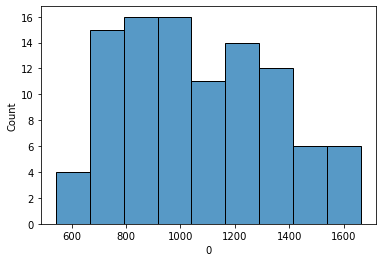

In [230]:
sns.histplot(predictions.iloc[0, :-2], bins=9)

<AxesSubplot:xlabel='1', ylabel='Count'>

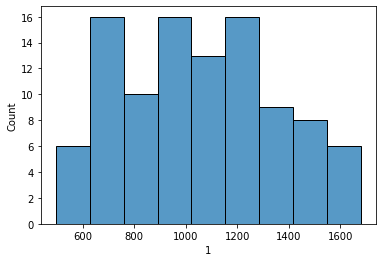

In [226]:
sns.histplot(predictions.iloc[1, :-2], bins=9)

<AxesSubplot:xlabel='2', ylabel='Count'>

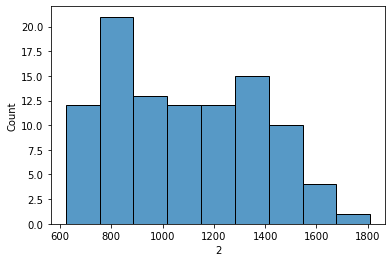

In [229]:
sns.histplot(predictions.iloc[2, :-2], bins=9)

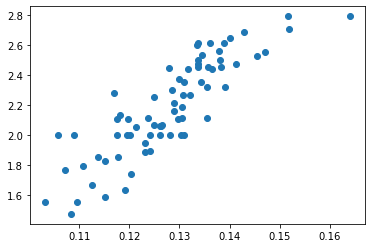

In [69]:
plt.scatter(dfProdFull["Porosity, fraction"], dfProdFull["Rock facies"])

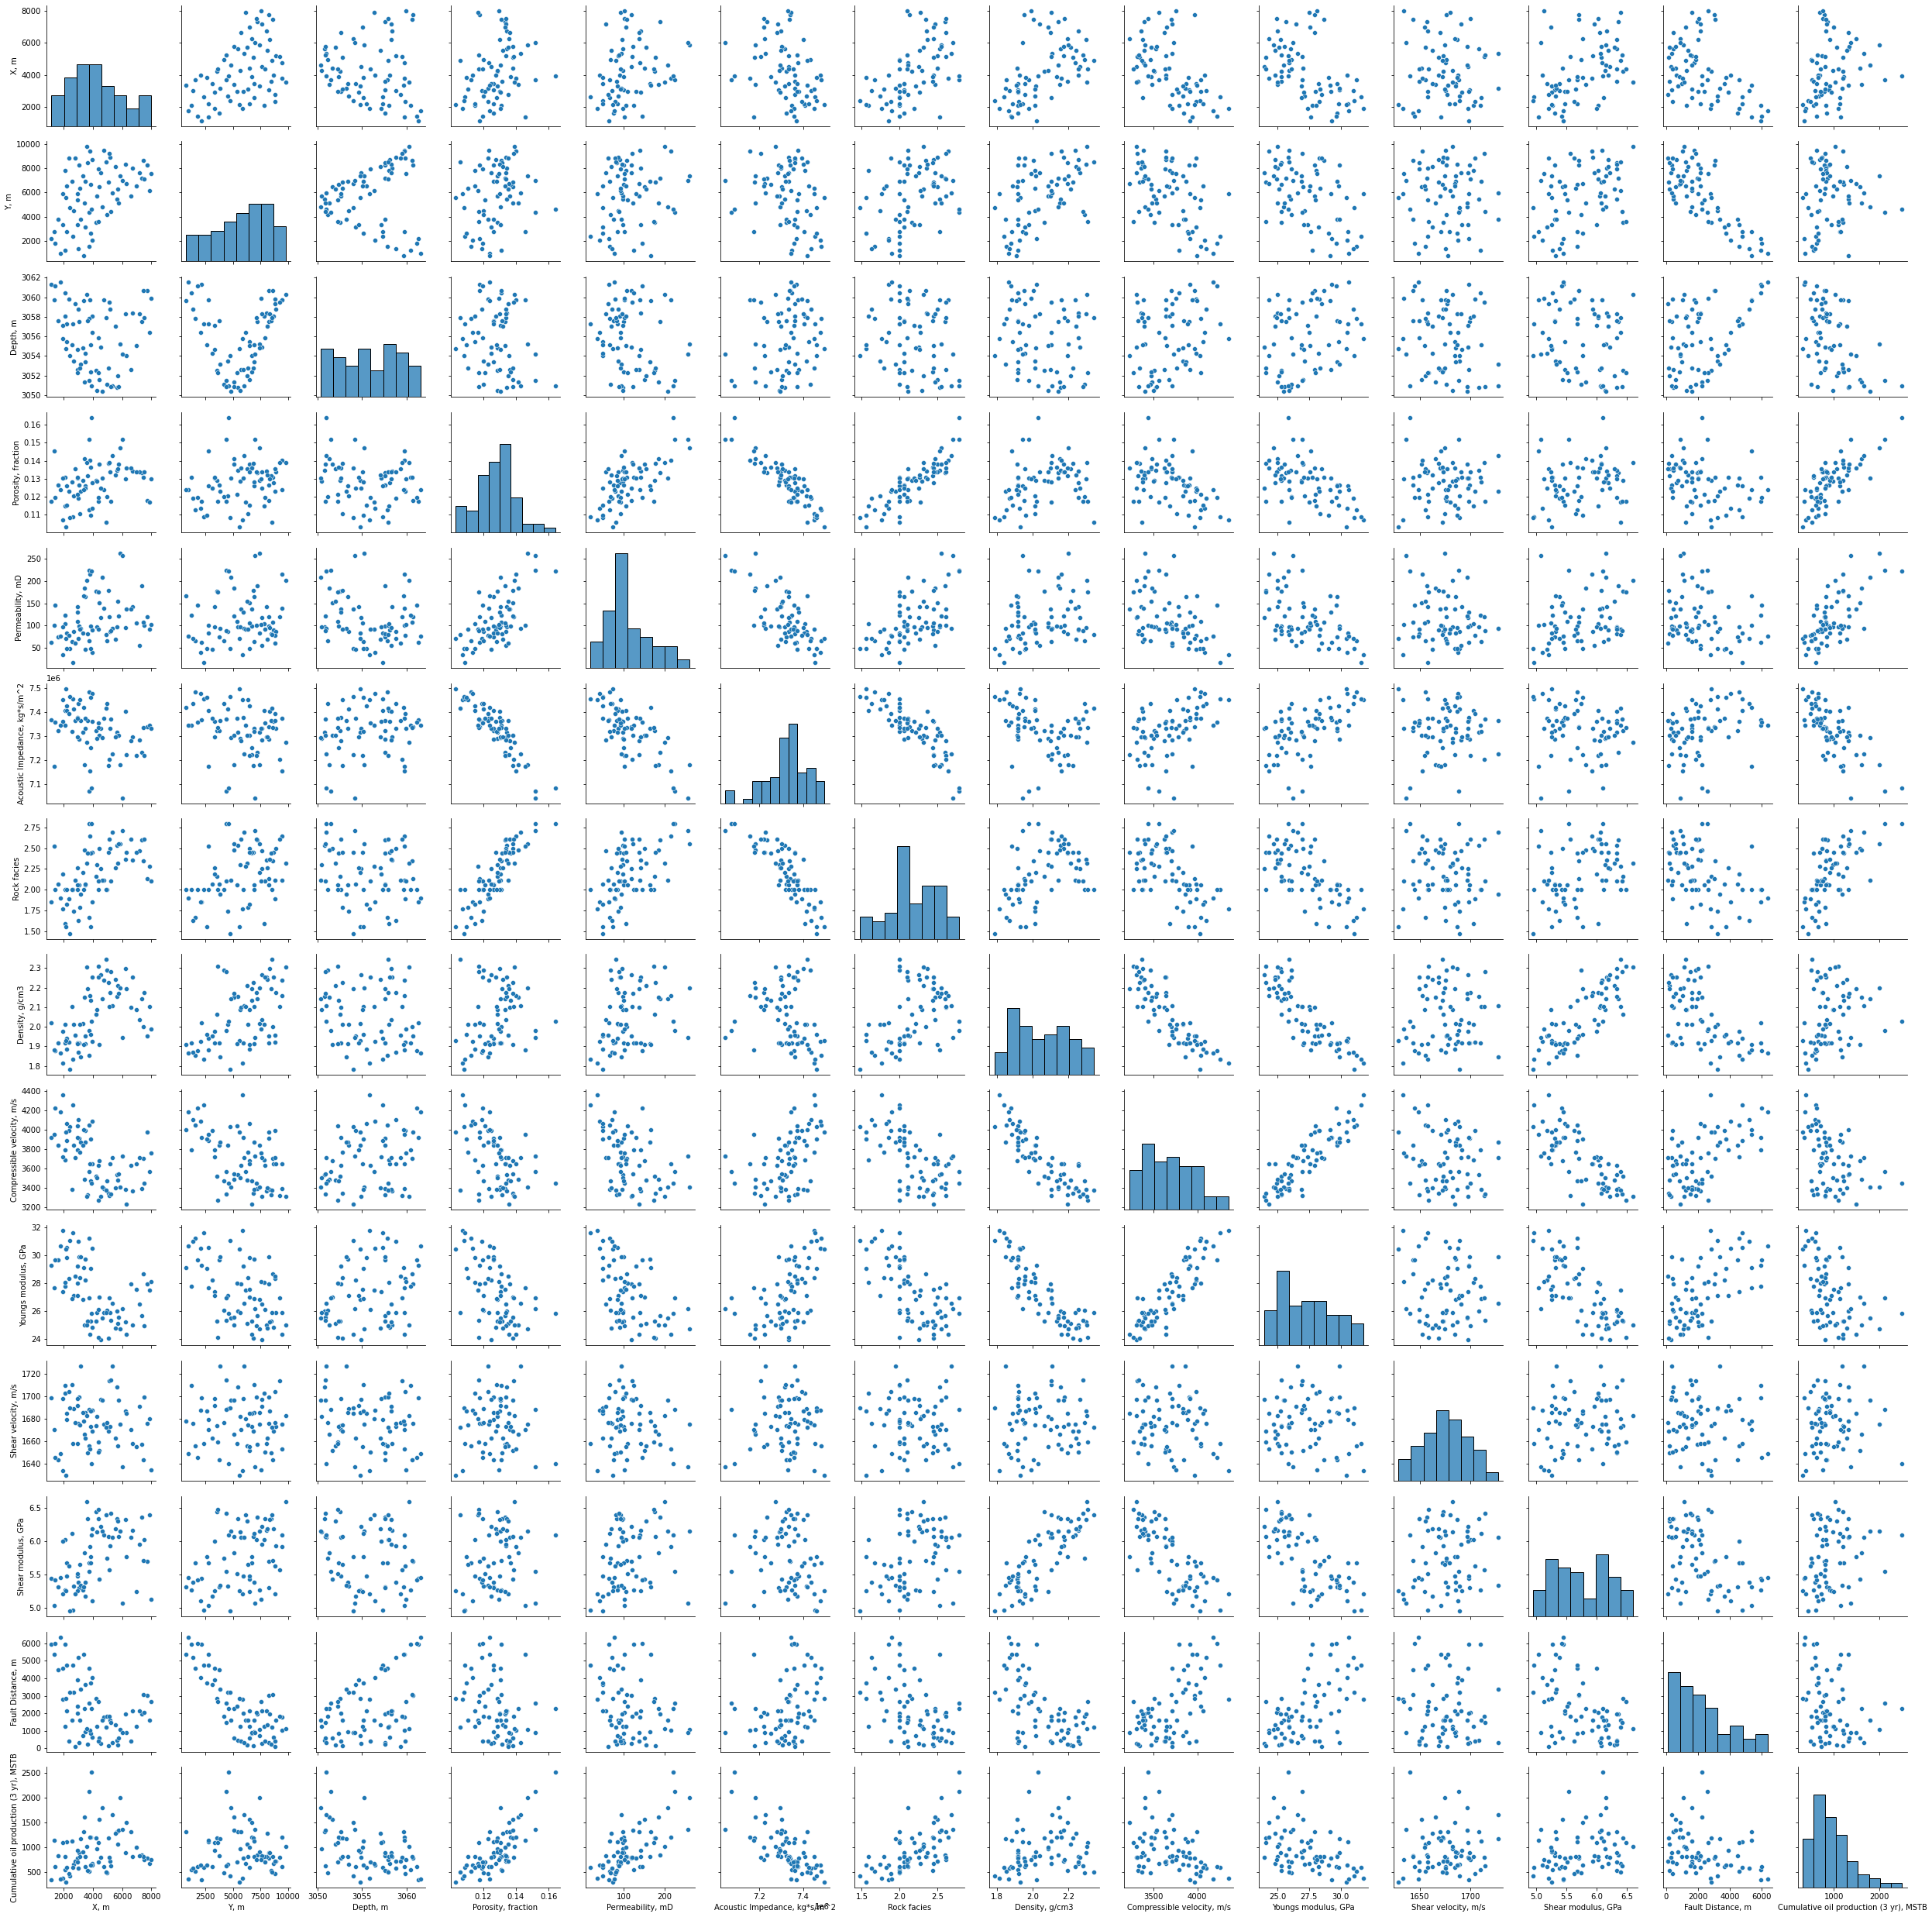

In [209]:
sns.pairplot(dfProdFinal)

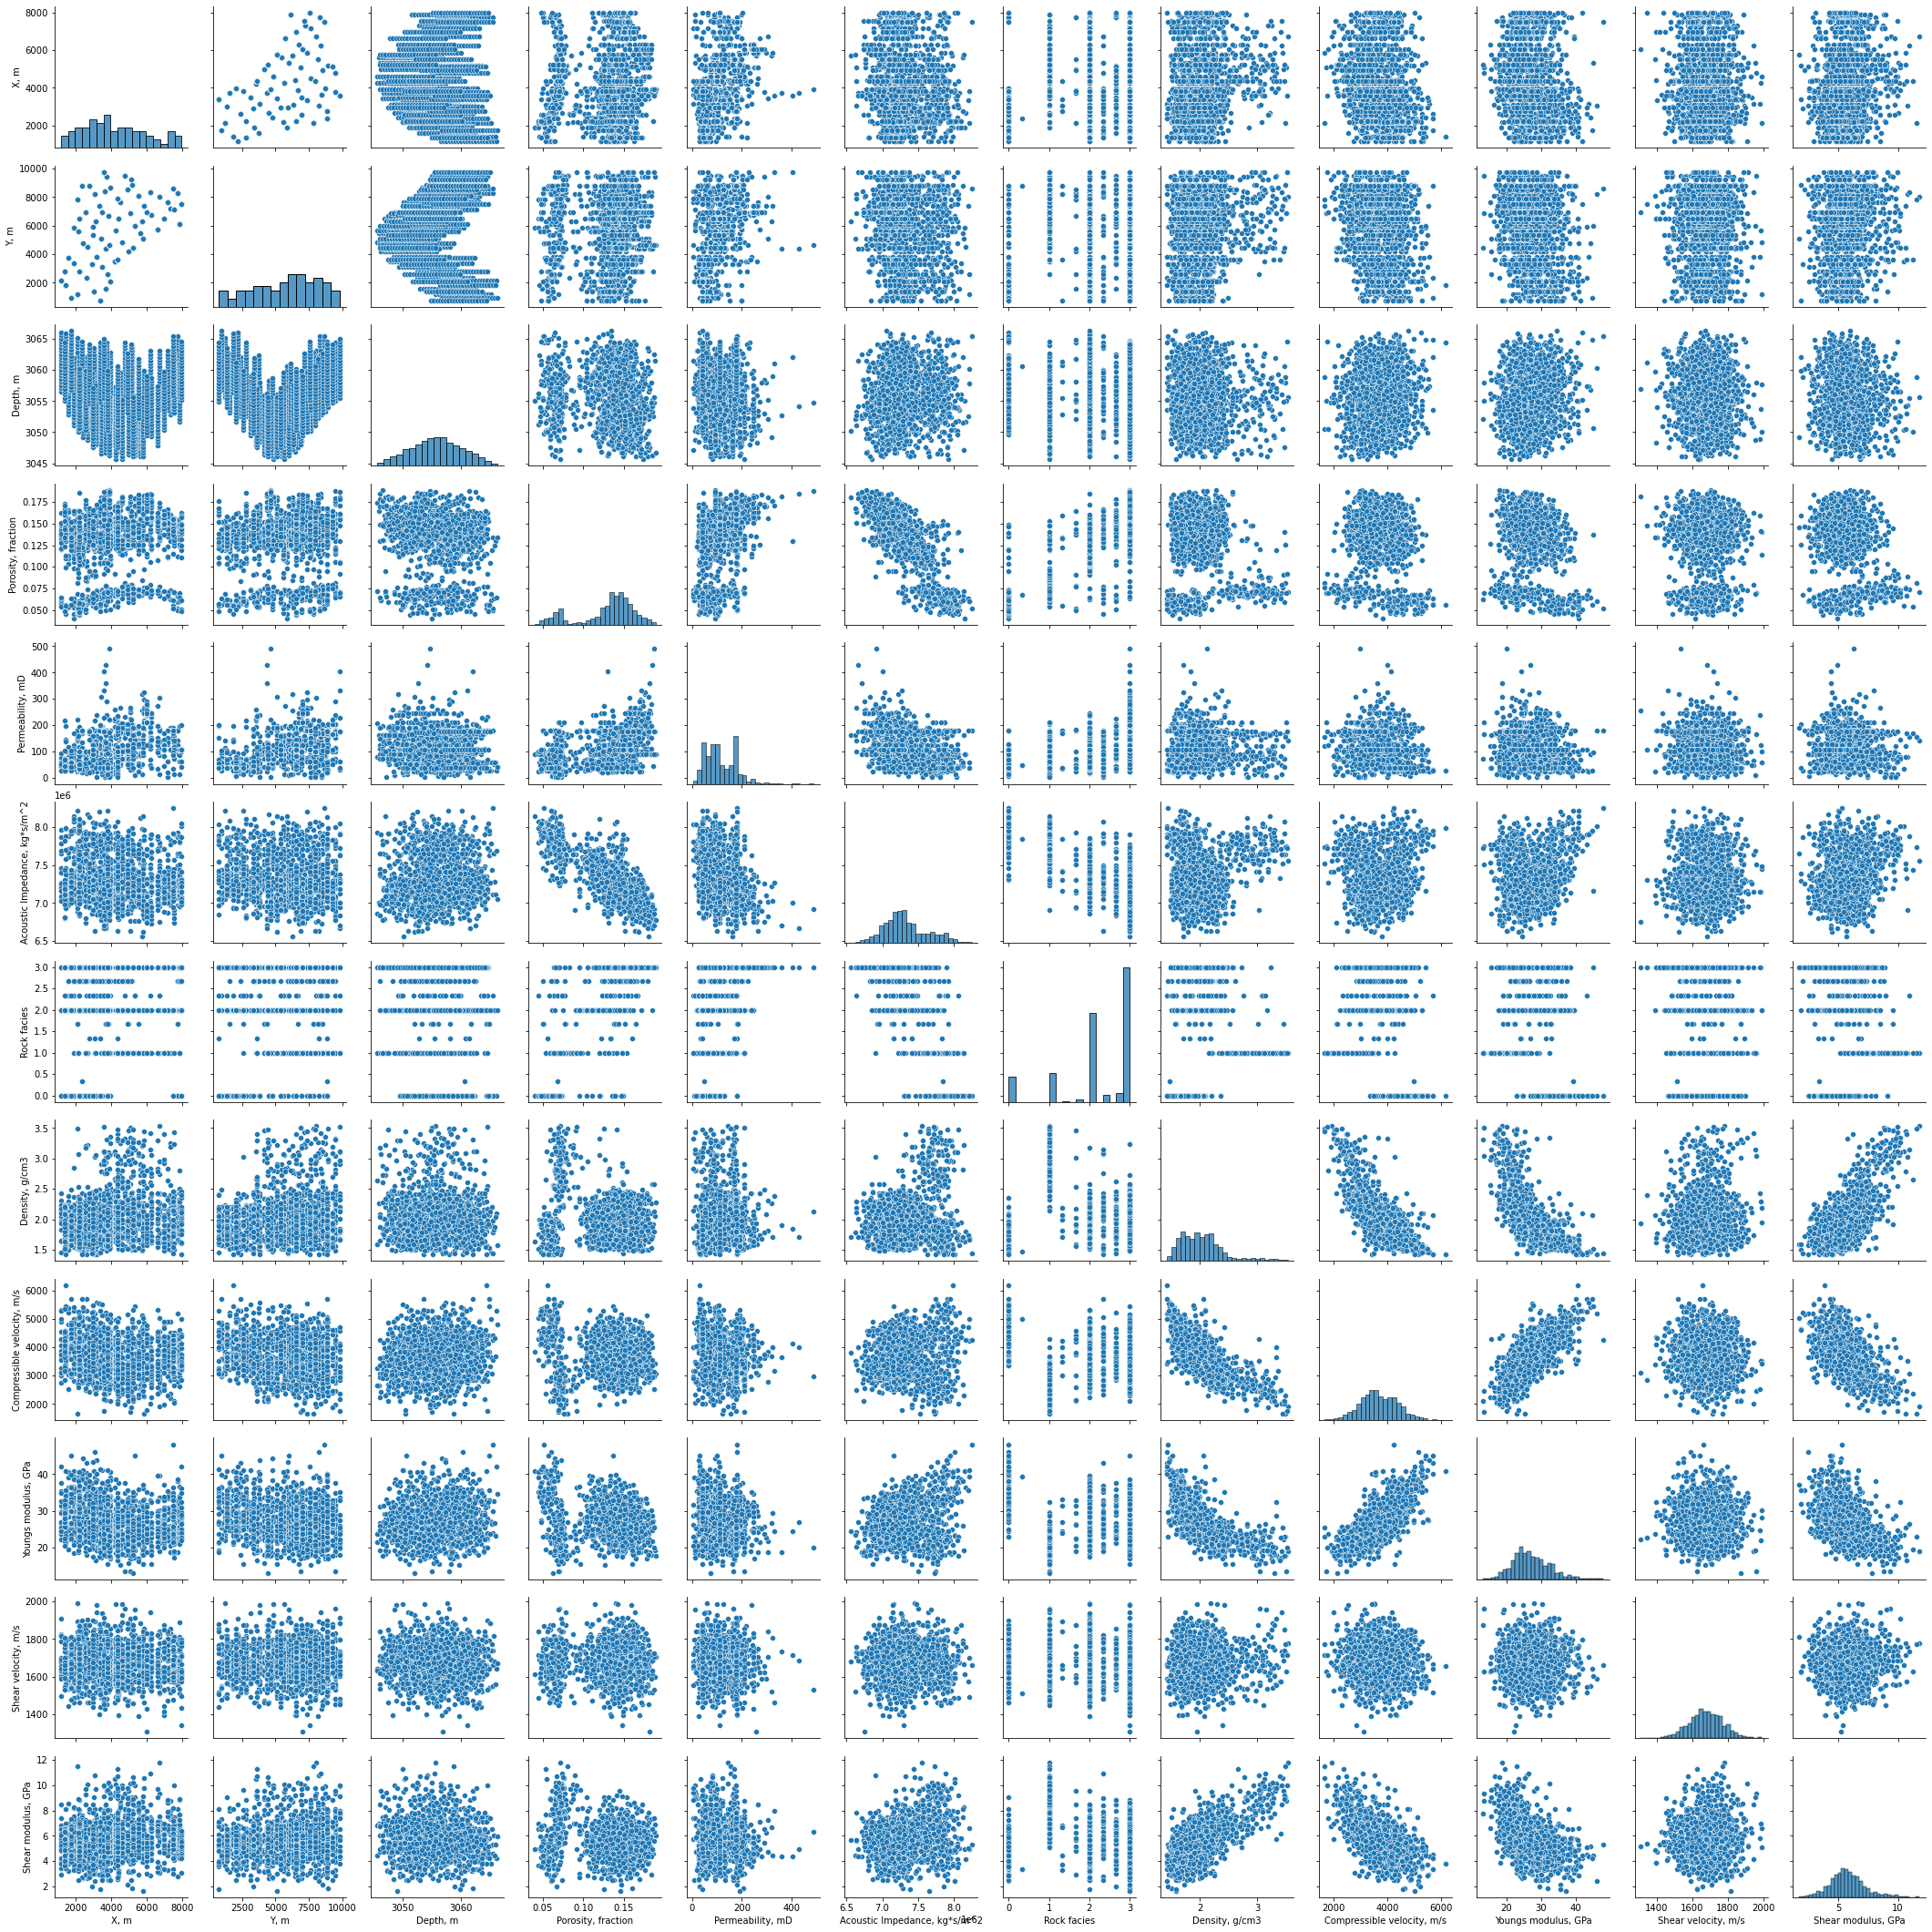

In [50]:
sns.pairplot(dfProdimputed)